# Lab: Aprendizaje por refuerzo multi-agente (II)

## Joint Action Learning with Game Theory, versión con redes neuronales

Un problema de la implementación de JAL-GT que vimos en la sesión anterior surge cuando tenemos un espacio de estados muy grande o continuo, o cuando queremos usar un histórico de observaciones como estado (como se define de forma abstracta la resolución teórica de un POSG).

Por ejemplo, en la práctica 3 de laboratorio (POGEMA) se propone, de partida, un espacio de observaciones de 3 matrices de booleanos de tamaño 9, que dan lugar a $2^{27}$ posibles observaciones. Esto se agravaría más si para tener una representación que pueda contener información histórica sobre el mapa (por ejemplo, para salir de un laberinto) necesitaríamos considerar un histórico de observaciones, haciendo que este espacio de estados crezca de manera exponencial.

La implementación de JAL-GT que hemos visto en la sesión anterior utiliza matrices para representar el valor Q. Sin embargo, no es necesario guardar la matriz completa con representación para todos los posibles estados para poder extraer información relevante para construir la política. Por ejemplo, puede que haya partes del espacio de estado que no sean importantes (por ejemplo, la casilla central en la matriz de agentes en POGEMA), o puede que haya elementos del estado que tenga sentido agrupar para extraer información importante (por ejemplo, para saber si no podemos movernos a una casilla no hace falta diferenciar entre obstáculo y agente).

Una manera de aligerar el espacio de estados es hacer _feature engineering_: extraer características del estado que sabemos que son relevantes y de esta manera comprimir la información. Por ejemplo, podríamos considerar que el agente está mirando siempre hacia el objetivo y podríamos reducir las observaciones que tenemos en cuenta sólo a aquellas que están en esa dirección.

Hay una manera automática de extraer estas características de manera automática: las redes neuronales, que permiten centrarse en técnicas denominadas como aprendizaje por refuerzo profundo (_Deep Reinforcement Learning_). La idea consiste en enviar las observaciones como entrada de la red neuronal y tener como salida, por ejemplo, el valor Q para cada acción, o directamente la política.

En esta sesión vamos a ver cómo aplicar esta técnica al algoritmo JAL-GT.

## Instalación y configuración

### Dependencias

In [1]:
!pip --quiet install rlcard pettingzoo seaborn matplotlib numpy pandas tinynn pygame


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports necesarios

In [2]:
import abc
import itertools
import random
import functools

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pettingzoo.classic import rps_v2
from tinynn.core.layer import Dense, ReLU
from tinynn.core.loss import MSE
from tinynn.core.model import Model
from tinynn.core.net import Net
from tinynn.core.optimizer import SGD

### Código de anteriores sesiones

In [3]:
RPS_CHOICES = ["Rock", "Paper", "Scissors"]
PD_CHOICES = ["Cooperate", "Defect"]

def pretty_print_array(ar):
    return np.array_str(np.array(ar), precision=2, suppress_small=True)

def draw_history(history, title):
    data = pd.DataFrame({'Episode': range(1, len(history) + 1), title: history})
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Episode', y=title, data=data)

    plt.title(title + ' Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel(title)
    plt.grid(True)
    plt.tight_layout()

    plt.show()


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


class GameModel:
    def __init__(self, num_agents, num_states, num_actions):
        self.num_agents = num_agents
        self.num_states = num_states
        self.num_actions = num_actions
        self.action_space = self.generate_action_space()
        self.action_space_index = {joint_action: idx for idx, joint_action in enumerate(self.action_space)}

    def generate_action_space(self):
        actions_by_players = []
        for agent_id in range(self.num_agents):
            actions_by_players.append(range(self.num_actions))
        all_joint_actions = itertools.product(*actions_by_players)
        return [tuple(l) for l in all_joint_actions]


class SolutionConcept(abc.ABC):
    @abc.abstractmethod
    def solution_policy(self, agent_id, state, game, q_models):
        pass


class MARLAlgorithm(abc.ABC):
    @abc.abstractmethod
    def learn(self, joint_action, rewards, state, next_state):
        pass

    @abc.abstractmethod
    def select_action(self, state):
        pass

## Redes neuronales

Utilizaremos una librería en Python que usa Numpy para calcular los gradientes. No usa GPU y no es tan eficiente ni tan potente como las librerías más usadas como Torch, Tensorflow o JAX pero ocupa mucho menos espacio de instalación.

Ejemplo de cómo declarar una red neuronal con una capa de entrada de 1 neurona, una capa oculta con 2 y una capa de salida con 1 neurona, usando ReLU como función de activación, con un _learning rate_ fijo de 0.001 y usando error de media de errores cuadrados como función de pérdida:

In [4]:
net = Net([Dense(1), ReLU(),
           Dense(2), ReLU(),
           Dense(1)])
model = Model(net=net, loss=MSE(), optimizer=SGD(0.001))

Ahora podemos usar esta red para entrenar, por ejemplo, una regresión lineal $y = 2 \cdot x + 1$ (le añadimos un poco de error):

In [5]:
X = [[4], [8], [10], [20]]
y = [[9.1], [16.8], [20.5], [41.1]]

predictions = [model.forward(np.array([x])) for x in X]  # .forward recibe un "batch"
predictions  # y devuelve un batch de predicciones por cada batch de entrada

[array([[0.]]), array([[0.]]), array([[0.]]), array([[0.]])]

Lo que predice en este punto no es relevante ya que la red aún no ha sido entrenada. La entrenamos:

In [6]:
for i in range(len(X)):
    target = np.array([y[i]])
    loss, gradients = model.backward(predictions[i], target)
    print(f"Loss: {loss}")
    model.apply_grads(gradients)

Loss: 41.404999999999994
Loss: 141.12
Loss: 210.125
Loss: 844.605


In [10]:
predictions = [model.forward(np.array([x])) for x in X]
predictions

[array([[0.0875]]), array([[0.0875]]), array([[0.0875]]), array([[0.0875]])]

Podríamos decir que ahora se ha pasado de vueltas. Podemos iterar hasta que la pérdida baje a una cantidad decente (por ejemplo, por debajo de 1):

In [11]:
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    for i in range(len(X)):
        print(X[i])
        print(y[i])
        prediction = model.forward(np.array([X[i]]))
        target = np.array([y[i]])
        loss, gradients = model.backward(prediction, target)
        if loss > 1:
            model.apply_grads(gradients)
        else:
            break
    if loss < 1:
        break
print(f"Loss: {loss}")

[4]
[9.1]
[8]
[16.8]
[10]
[20.5]
[20]
[41.1]
[4]
[9.1]
[8]
[16.8]
[10]
[20.5]
[20]
[41.1]
[4]
[9.1]
[8]
[16.8]
[10]
[20.5]
[20]
[41.1]
[4]
[9.1]
[8]
[16.8]
[10]
[20.5]
[20]
[41.1]
[4]
[9.1]
[8]
[16.8]
[10]
[20.5]
[20]
[41.1]
[4]
[9.1]
[8]
[16.8]
[10]
[20.5]
[20]
[41.1]
[4]
[9.1]
[8]
[16.8]
[10]
[20.5]
[20]
[41.1]
[4]
[9.1]
[8]
[16.8]
[10]
[20.5]
[20]
[41.1]
[4]
[9.1]
[8]
[16.8]
[10]
[20.5]
[20]
[41.1]
[4]
[9.1]
[8]
[16.8]
[10]
[20.5]
[20]
[41.1]
Loss: 807.9190708651736


Podemos inspeccionar los pesos (w) y los sesgos (b) de cada neurona:

In [12]:
net.params.values

array([array([[-0.43037045]]), array([0.]),
       array([[-0.2590569 ,  1.38151383]]), array([0., 0.]),
       array([[ 0.89978379],
              [-0.71103227]]), array([0.94270824])], dtype=object)

Comprobemos que se ajusta bien:

In [13]:
predictions = [model.forward(np.array([x])) for x in X]
predictions

[array([[0.94270824]]),
 array([[0.94270824]]),
 array([[0.94270824]]),
 array([[0.94270824]])]

Y que podemos predecir cualquier valor con cierto margen de error:

In [14]:
model.forward(np.array([[200], [500]]))

array([[0.94270824],
       [0.94270824]])

## Aplicando redes neuronales a JAL-GT

Lo primero que necesitaremos será poder tratar un estado como un vector, para poder pasarlo como entrada a una red neuronal. Para ello usaremos el método de _one-hot encoding_:

In [15]:
@functools.cache
def one_hot(index, total_length):
    one_hot_vector = np.zeros(total_length)
    one_hot_vector[index] = 1
    return np.array([one_hot_vector], dtype=float)

### Adaptando el algoritmo

Primero vamos a modificar el algoritmo. En la constructora, en vez de una matriz $N \times S \times AS$ (agentes x estados x acciones conjuntas), vamos a usar una lista de redes neuronales, una por cada agente del cual estamos modelando su valor Q.

Algunos métodos, como la función para obtener la política a partir de la solución de concepto (`update_policy`), apenas cambian.

In [16]:
class JALGTNN(MARLAlgorithm):
    def __init__(self, agent_id, game: GameModel, solution_concept: SolutionConcept,
                 gamma=0.95, alpha=0.5, epsilon=0.2, seed=42):
        self.agent_id = agent_id
        self.game = game
        self.solution_concept = solution_concept
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.rng = random.Random(seed)
        # Política conjunta por defecto: distribución uniforme respecto
        # de las acciones conjuntas, para cada acción (pi(a | s))
        self.joint_policy = np.ones((self.game.num_agents, self.game.num_states,
                                     self.game.num_actions)) / self.game.num_actions
        self.metrics = {"td_error": [], "loss": []}

        # Red neuronal: 64 neuronas de entrada, 32 en la capa oculta,
        # |AS| (cardinalidad del espacio de acciones conjuntas) en la capa de salida
        # Es decir, un valor Q de salida para cada acción conjunta
        net = [Net([Dense(64), ReLU(),
                    Dense(32), ReLU(),
                    Dense(len(self.game.action_space))])
               for _ in range(self.game.num_agents)]
        optimizers = [SGD(lr=self.alpha) for _ in range(self.game.num_agents)]
        self.q_models = [Model(net=net[i], loss=MSE(), optimizer=optimizers[i])
                         for i in range(self.game.num_agents)]

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def update_policy(self, agent_id, state):
        self.joint_policy[agent_id][state] = self.solution_concept.solution_policy(agent_id, state, self.game, self.q_models)

    def solve(self, agent_id, state):
        return self.joint_policy[agent_id][state]

    def select_action(self, state, train=True):
        if train and self.rng.random() < self.epsilon:
            return self.rng.choice(range(self.game.num_actions))
        else:
            probs = self.solve(self.agent_id, state)
            np.random.seed(self.rng.randint(0, 10000))
            return np.random.choice(range(self.game.num_actions), p=probs)

Cambiamos la función de valor de estado para un agente para utilizar la predicción (`.forward()`) de la red neuronal:

In [17]:
class JALGTNN(JALGTNN):
    def value(self, agent_id, state):
        value = 0
        for idx, joint_action in enumerate(self.game.action_space):
            payoff = self.q_models[agent_id].forward(one_hot(state, self.game.num_states))[0][idx]
            joint_probability = np.prod([self.joint_policy[i][state][joint_action[i]]
                                         for i in range(self.game.num_agents)])
            value += payoff * joint_probability
        return value

Añadimos un método para encapsular la lógica de actualización de la red neuronal para el valor Q de un agente para un estado, dados un valor para el estado siguiente (función $Value$ que vimos en la sesión anterior) y la recompensa inmediata.

Los pasos con una red neuronal son los siguientes:

* Obtenemos las predicciones actuales para el valor $Q(s, a)$.
* Calculamos el objetivo de diferencia temporal (_TD target_), que es el componente que según la fórmula de actualización en el algoritmo de diferencias temporales es la recompensa más el valor futuro descontado.
* En una copia de las predicciones, modificamos el valor correspondiente a la acción conjunta recién ejecutada para poner el valor objetivo.
* Dejamos que la librería de redes neuronales calcule los gradientes a modificar en las neuronas de la red. Este proceso es análogo a la resta $r + \gamma\cdot value - Q(s,a)$.
* Aplicamos estos gradientes a la red. Implícitamente se aplica la tasa de aprendizaje, por lo que es un proceso análogo a $Q(s,a) \leftarrow Q(s,a) + \alpha \left[r + \gamma\cdot value - Q(s,a)\right]$.

In [18]:
class JALGTNN(JALGTNN):
    def update_q(self, q_model, state, action, reward, next_value):
        prediction = q_model.forward(state)[0]
        agent_q_value = prediction[action]
        td_target = reward + self.gamma * next_value
        td_error = td_target - agent_q_value
        target = prediction.copy()
        target[action] = td_target
        loss, grads = q_model.backward(np.array([prediction]), np.array([target]))
        q_model.apply_grads(grads)
        return td_error, loss

Modificamos el método `learn` para utilizar el método de actualización de Q que acabamos de ver. Es importante hacer la conversión del estado en su representación vectorial (e.g. el estado 3 en un entorno con 4 estados sería `[0 0 0 1]`, o el estado 0 en un entorno con 1 estado como un juego en forma normal sería `[1]`:


In [19]:
class JALGTNN(JALGTNN):
    def learn(self, joint_action, rewards, state, next_state):
        joint_action_index = self.game.action_space_index[joint_action]
        for agent_id in range(self.game.num_agents):
            agent_reward = rewards[agent_id]
            agent_game_value_next_state = self.value(agent_id, next_state)
            one_hot_state = one_hot(state, self.game.num_states)
            td_error, loss = self.update_q(self.q_models[agent_id], one_hot_state,
                                           joint_action_index, agent_reward,
                                           agent_game_value_next_state)
            self.update_policy(agent_id, state)
            # Guardamos el error de diferencia temporal y la pérdida de la red neuronal para estadísticas posteriores
            self.metrics['td_error'].append(abs(td_error))
            self.metrics['loss'].append(abs(loss))

Con esto ya tenemos un algoritmo JAL-GT adaptado para poder utilizar espacios de estados arbitrariamente grandes.

### Conceptos de solución

Como a los conceptos de solución, en la implementación de la sesión anterior, pasábamos la matriz Q, ahora tenemos que adaptarlos para utilizar la red neuronal, usando `.forward` donde sea necesario obtener los valores Q.

#### Pareto-eficiencia

In [20]:
class ParetoSolutionConcept(SolutionConcept):
    def is_dominated(self, joint_action, other_joint_action, scalar_state, game, q_models):
        strictly_better_for_at_least_one = False
        state = one_hot(scalar_state, game.num_states)
        for agent_id in range(game.num_agents):
            joint_action_index = game.action_space_index[joint_action]
            other_joint_action_index = game.action_space_index[other_joint_action]

            q_state = q_models[agent_id].forward(state)[0]
            q_state_a_i = q_state[joint_action_index]
            q_state_a_j = q_state[other_joint_action_index]

            if q_state_a_j < q_state_a_i:
                return False
            if q_state_a_j > q_state_a_i:
                strictly_better_for_at_least_one = True
        return strictly_better_for_at_least_one

    def find_pareto_efficient_solutions(self, state, game, q_models):
        joint_actions = list(itertools.product(range(game.num_actions), repeat=game.num_agents))
        pareto_solutions = []

        for joint_action in joint_actions:
            dominated = False
            for other_joint_action in joint_actions:
                if other_joint_action == joint_action:
                    continue
                if self.is_dominated(joint_action, other_joint_action, state, game, q_models):
                    dominated = True
                    break
            if not dominated:
                pareto_solutions.append(joint_action)

        return pareto_solutions

    def solution_policy(self, agent_id, state, game, q_models):
        pareto_solutions = self.find_pareto_efficient_solutions(state, game, q_models)
        if len(pareto_solutions) > 0:
            action_counts = np.zeros(game.num_actions)
            for pareto_solution in pareto_solutions:
                action_counts[pareto_solution[agent_id]] += 1
            probs = action_counts / len(pareto_solutions)
            return probs
        else:
            uniform_distribution = np.ones(game.num_actions)
            return uniform_distribution / np.sum(uniform_distribution)

#### Minimax

In [21]:
class MinimaxSolutionConcept(SolutionConcept):
    def opponent_max_values(self, agent_id, scalar_state, game, q_models):
        action_scores = []
        q_opponent = q_models[1 - agent_id]
        state = one_hot(scalar_state, game.num_states)
        for action in range(game.num_actions):
            max_opponent_payoff = -999999999999
            for opponent_action in range(game.num_actions):
                if agent_id == 0:  # Suponemos sólo dos agentes
                    joint_action = (action, opponent_action)
                else:
                    joint_action = (opponent_action, action)
                joint_action_index = game.action_space_index[joint_action]
                score = q_opponent.forward(state)[0][joint_action_index]
                if score > max_opponent_payoff:
                    max_opponent_payoff = score
            action_scores.append(max_opponent_payoff)
        return np.array(action_scores)

    def solution_policy(self, agent_id, state, game, q_models):
        vals = np.array(self.opponent_max_values(agent_id, state, game, q_models))
        return softmax(-vals)

#### Equilibrio de Nash

In [22]:
class NashSolutionConcept(SolutionConcept):
    def generate_others_actions(self, fixed_agent_id, num_agents, num_actions):
        # Lista con las estrategias que pueden seguir los demás agentes
        strategies_minus_me = [range(num_actions) if i != fixed_agent_id else [None]
                               for i in range(num_agents)]
        # itertools.product nos da el producto cartesiano
        return list(itertools.product(*strategies_minus_me))

    def calculate_best_responses(self, agent_id, scalar_state, game, q_models):
        state = one_hot(scalar_state, game.num_states)
        others_joint_actions = self.generate_others_actions(agent_id, game.num_agents, game.num_actions)
        best_responses = []
        for joint_action in others_joint_actions:
            max_payoff = float('-inf')
            best_response = None
            for action in range(game.num_actions):
                joint_action_copy = list(joint_action)
                joint_action_copy[agent_id] = action
                full_joint_action = tuple(joint_action_copy)
                joint_action_index = game.action_space.index(full_joint_action)
                q_state = q_models[agent_id].forward(state)[0]
                payoff = q_state[joint_action_index]
                if payoff > max_payoff:
                    max_payoff = payoff
                    best_response = full_joint_action
            best_responses.append(best_response)
        return set(best_responses)

    def find_nash_equilibria(self, state, game, q_models):
        best_responses = [self.calculate_best_responses(i, state, game, q_models) for i in range(game.num_agents)]
        return list(set.intersection(*best_responses))

    def solution_policy(self, agent_id, state, game, q_models):
        nash_equilibria = self.find_nash_equilibria(state, game, q_models)
        if len(nash_equilibria) > 0:
            equilibrium = nash_equilibria[0]
            probs = np.zeros(game.num_actions)
            probs[equilibrium[agent_id]] = 1
            return probs
        else:
            uniform_distribution = [1] * game.num_actions
            return uniform_distribution / np.sum(uniform_distribution)

#### Bienestar

In [23]:
class WelfareSolutionConcept(SolutionConcept):
    def find_welfare_maximizing_solutions(self, state, game, q_models):
        joint_actions = list(itertools.product(range(game.num_actions), repeat=game.num_agents))
        welfare_values = []

        for joint_action in joint_actions:
            welfare = self.calculate_welfare(joint_action, state, game, q_models)
            welfare_values.append((welfare, joint_action))

        max_welfare = max(welfare_values, key=lambda x: x[0])[0]
        welfare_maximizing_solutions = [action for welfare, action in welfare_values if welfare == max_welfare]

        return welfare_maximizing_solutions

    def calculate_welfare(self, joint_action, state, game, q_models):
        welfare = 0
        joint_action_index = game.action_space_index[joint_action]
        for agent_id in range(game.num_agents):
            q_state = q_models[agent_id].forward(one_hot(state, game.num_states))[0]
            welfare += q_state[joint_action_index]
        return welfare

    def solution_policy(self, agent_id, state, game, q_models):
        welfare_solutions = self.find_welfare_maximizing_solutions(state, game, q_models)
        num_solutions = len(welfare_solutions)

        if num_solutions > 0:
            # Initialize probability distribution for the agent's actions
            probs = np.zeros(game.num_actions)

            # Calculate the probability assigned to each action
            for solution in welfare_solutions:
                probs[solution[agent_id]] += 1 / num_solutions

            return probs
        else:
            uniform_distribution = np.ones(game.num_actions)
            return uniform_distribution / np.sum(uniform_distribution)

## Entrenamiento

A continuación definimos una función para entrenar basada en el código de la sesión anterior, parametrizable con un entorno, un modelo de juego, los algoritmos para cada agente y una función para convertir observaciones en estados. Añadimos también una función para convertir observaciones en el estado único para juegos en forma normal, que nos servirá para Rock, Paper, Scissors y el dilema del prisionero:

In [24]:
def normal_form_obs_to_state(observation):
    # Sólo un estado (juego en forma normal)
    return 0

def train(env, game, f_obs_to_state, algorithms):
    cumulative_rewards = [[0, 0]]
    actions_played = [[], []]
    all_agents = range(game.num_agents)

    observations, _ = env.reset()
    states = [f_obs_to_state(observations[f"player_{i}"]) for i in all_agents]
    while env.agents:
        # Selección de acción conjunta
        joint_action = tuple([algorithms[i].select_action(states[i]) for i in all_agents])
        [actions_played[i].append(joint_action[i]) for i in all_agents]
        pettingzoo_joint_action = {f"player_{i}": joint_action[i] for i in all_agents}

        # Actualización del entorno
        observations, rewards, terminations, truncations, infos = env.step(pettingzoo_joint_action)

        # Aprendizaje
        observations = [observations[f"player_{i}"] for i in all_agents]
        rewards = [rewards[f"player_{i}"] for i in all_agents]
        new_states = [f_obs_to_state(observations[i]) for i in all_agents]
        [algorithms[i].learn(joint_action, rewards, states[i], new_states[i])
         for i in all_agents]
        cumulative_rewards.append([cumulative_rewards[-1][i] + rewards[i] for i in all_agents])

        # Actualizamos estado
        states = new_states

    return cumulative_rewards, actions_played

### Experimento: Rock, Paper, Scissors

In [25]:
def train_rps_2_agents(solution_concept, num_turns, gammas, alphas, epsilons, seeds):
    game_model = GameModel(num_agents=2, num_states=1, num_actions=3)
    algorithm_player_0 = JALGTNN(0, game_model, solution_concept,
                                 gamma=gammas[0], alpha=alphas[0],
                                 epsilon=epsilons[0], seed=seeds[0])
    algorithm_player_1 = JALGTNN(1, game_model, solution_concept,
                                 gamma=gammas[1], alpha=alphas[1],
                                 epsilon=epsilons[1], seed=seeds[1])
    env = rps_v2.parallel_env(max_cycles=num_turns, render_mode="ansi")
    cumulative_rewards, actions_played = train(env, game_model, normal_form_obs_to_state,
                                               [algorithm_player_0, algorithm_player_1])
    env.close()
    return game_model, algorithm_player_0, algorithm_player_1, cumulative_rewards, actions_played

**Prueba diferentes combinaciones de soluciones de concepto y número de turnos para comprobar el comportamiento de JAL-GT con redes neuronales. Puedes abrir en otra pestaña el notebook de la sesión anterior para comparar el rendimiento tanto en optimalidad de política como en eficiencia temporal.**

**¿Qué interpretación le das a los resultados en convergencia de cada solución de concepto?**

In [30]:
game_model, algorithm_player_0, algorithm_player_1, cumulative_rewards, actions_played = \
        train_rps_2_agents(solution_concept=ParetoSolutionConcept(),
                           num_turns=500, gammas=[0.95, 0.95], alphas=[0.01, 0.01],
                           epsilons=[0.2, 0.2], seeds=[0, 1])

# Recompensa acumulada. Debería ser [0, 0] en el infinito, si las estrategias son óptimas
print(f"Recompensas acumuladas: {cumulative_rewards[-1][0]}, {cumulative_rewards[-1][1]}")

# Espacio de acciones conjuntas
print(f"Espacio de acciones conjuntas ordenado: {game_model.action_space}")

Recompensas acumuladas: 1, -1
Espacio de acciones conjuntas ordenado: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


In [31]:
# Valores Q calculados por los dos agentes:
print("Valores Q calculados por el agente 0 sobre el agente 0, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_models[0].forward(one_hot(0, game_model.num_states))[0]))
print("Valores Q calculados por el agente 0 sobre el agente 1, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_models[1].forward(one_hot(0, game_model.num_states))[0]))
print("Valores Q calculados por el agente 1 sobre el agente 0, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_1.q_models[0].forward(one_hot(0, game_model.num_states))[0]))
print("Valores Q calculados por el agente 1 sobre el agente 1, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_1.q_models[1].forward(one_hot(0, game_model.num_states))[0]))

# Convertimos en un dataframe para mostrar la matriz de recompensas para el agente 0:
df = pd.DataFrame(np.array(algorithm_player_0.q_models[0]
                           .forward(one_hot(0, game_model.num_states)))
                  .reshape((len(RPS_CHOICES), len(RPS_CHOICES))),
                  index=RPS_CHOICES, columns=RPS_CHOICES)
print("Matriz de recompensas estimadas para el agente 0:")
print(df)

# Política del agente 0:
print(f"Política del agente 0: {algorithm_player_0.solve(0, 0)}")

# Política del agente 1:
print(f"Política del agente 1: {algorithm_player_0.solve(0, 0)}")

Valores Q calculados por el agente 0 sobre el agente 0, indexados por acciones conjuntas:
[ 0.01 -0.95  1.03  0.85 -0.08 -1.   -0.94  1.06  0.01]
Valores Q calculados por el agente 0 sobre el agente 1, indexados por acciones conjuntas:
[ 0.01  1.02 -1.02 -0.91 -0.09  1.01  1.   -0.95  0.01]
Valores Q calculados por el agente 1 sobre el agente 0, indexados por acciones conjuntas:
[-0.1  -0.95  0.98  0.78 -0.42 -0.95 -0.94  0.7  -0.01]
Valores Q calculados por el agente 1 sobre el agente 1, indexados por acciones conjuntas:
[-0.04  0.91 -1.13 -0.79 -0.12  0.93  0.9  -0.9  -0.04]
Matriz de recompensas estimadas para el agente 0:
              Rock     Paper  Scissors
Rock      0.006807 -0.948623  1.031006
Paper     0.846657 -0.076124 -1.003699
Scissors -0.935164  1.060106  0.011232
Política del agente 0: [0.2 0.2 0.6]
Política del agente 1: [0.2 0.2 0.6]


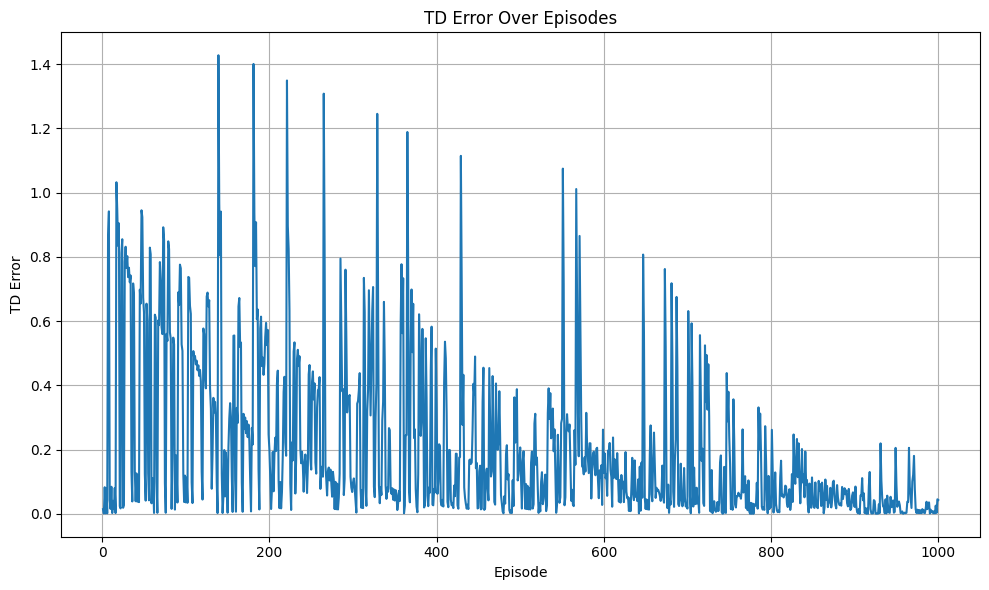

In [32]:
draw_history(algorithm_player_0.metrics["td_error"], "TD Error")

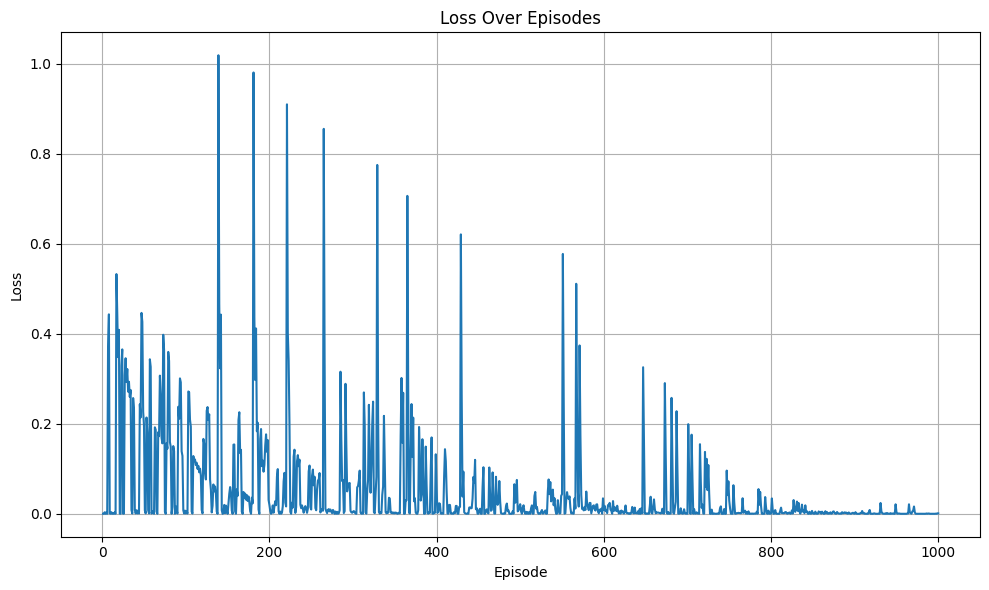

In [33]:
draw_history(algorithm_player_0.metrics["loss"], "Loss")

Antes de cerrar, fijaos en la estructura de la red neuronal. Estamos usando un total de 121 neuronas en las tres capas. Para espacios de estados con mucha complejidad, puede ser un tamaño adecuado, pero para estos problemas en forma normal, no hace falta (de hecho, sólo tenemos un estado). **Prueba a modificar la estructura para encontrar un tamaño lo suficientemente pequeño como para que los resultados de los experimentos no se resientan.**

### Experimento: dilema del prisionero

De nuevo, este es el código del entorno del dilema del prisionero:

In [ ]:
import prisoners_dilemma

Código de entrenamiento:

In [ ]:
def train_pd(solution_concept, num_turns, gammas, alphas, epsilons, seeds):
    game_model = GameModel(num_agents=2, num_states=1, num_actions=2)
    algorithm_player_0 = JALGTNN(0, game_model, solution_concept,
                                 gamma=gammas[0], alpha=alphas[0],
                                 epsilon=epsilons[0], seed=seeds[0])
    algorithm_player_1 = JALGTNN(1, game_model, solution_concept,
                                 gamma=gammas[1], alpha=alphas[1],
                                 epsilon=epsilons[1], seed=seeds[1])
    env = prisoners_dilemma.parallel_env(max_cycles=num_turns, render_mode="ansi")
    cumulative_rewards, actions_played = train(env, game_model, normal_form_obs_to_state,
                                               [algorithm_player_0, algorithm_player_1])
    return game_model, algorithm_player_0, algorithm_player_1, cumulative_rewards, actions_played

In [ ]:
game_model, algorithm_player_0, algorithm_player_1, cumulative_rewards, actions_played = \
    train_pd(solution_concept=NashSolutionConcept(),
             num_turns=5000, gammas=[0.95, 0.95], alphas=[0.01, 0.01],
             epsilons=[0.2, 0.2], seeds=[0, 1])

# Recompensa acumulada
print(f"Recompensas acumuladas: {cumulative_rewards[-1][0]}, {cumulative_rewards[-1][1]}")

# Espacio de acciones conjuntas
print(f"Espacio de acciones conjuntas ordenado: {game_model.action_space}")

# Valores Q calculados por los dos agentes:
print("Valores Q calculados por el agente 0 sobre el agente 0, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_models[0].forward(one_hot(0, game_model.num_states))))
print("Valores Q calculados por el agente 0 sobre el agente 1, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_models[1].forward(one_hot(0, game_model.num_states))))
print("Valores Q calculados por el agente 1 sobre el agente 0, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_1.q_models[0].forward(one_hot(0, game_model.num_states))))
print("Valores Q calculados por el agente 1 sobre el agente 1, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_1.q_models[1].forward(one_hot(0, game_model.num_states))))

# Convertimos en un dataframe para mostrar la matriz de recompensas para el agente 0:
df = pd.DataFrame(np.array(algorithm_player_0.q_models[0]
                           .forward(one_hot(0, game_model.num_states)))
                  .reshape((len(PD_CHOICES), len(PD_CHOICES))),
                  index=PD_CHOICES, columns=PD_CHOICES)
print("Matriz de recompensas estimadas para el agente 0:")
print(df)

# Política del agente 0:
print(f"Política del agente 0: {algorithm_player_0.solve(0, 0)}")

# Política del agente 1:
print(f"Política del agente 1: {algorithm_player_0.solve(0, 0)}")

In [ ]:
draw_history(algorithm_player_0.metrics["td_error"], "TD Error")

In [ ]:
draw_history(algorithm_player_0.metrics["loss"], "Loss")